In [2]:
## plot within the notebook
%matplotlib inline
import warnings
import numpy as np
## No annoying warnings
warnings.filterwarnings('ignore')

In [3]:
import astrobject.simulation as simul
tr = simul.transient_generator([0.01,0.1], ratekind="basiclow", type_="Ia")
# ratekind is the rate of the transient: basiclow = 1e3 
# -> comoving volumetric rate at each redshift in units of yr^-1 Mpc^-3.
# type_ is the type of transient. 
# This will parse the ratekind+type_ do get the good rate function

In [4]:
from astrobject.utils.plot.skybins import SurveyFieldBins
ztf_fields = np.genfromtxt('data/ZTF_Fields.txt', comments='%')
bins = SurveyFieldBins(ra=ztf_fields[:,1], dec=ztf_fields[:,2])
# Fields are defined by their midpoints
# Default width and height are set to 7 degrees for now
# There is more field overlap the closer you get to the poles (no surprise)

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x7ff72333ded0>,
 'cbar': <matplotlib.colorbar.ColorbarBase at 0x7ff7214a4150>,
 'collection': <matplotlib.collections.PolyCollection at 0x7ff7215fa7d0>,
 'figure': <matplotlib.figure.Figure at 0x7ff732450910>}

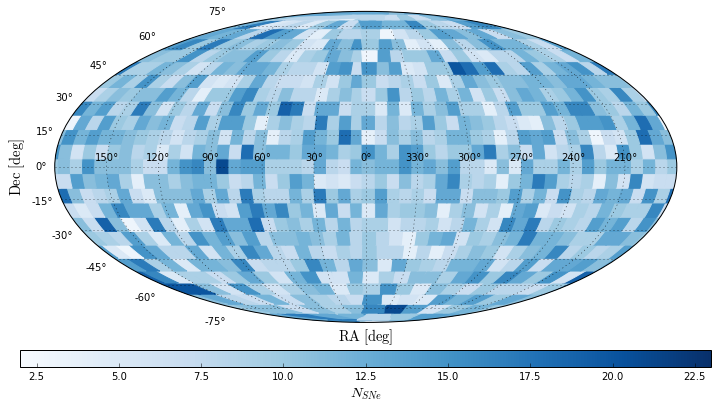

In [5]:
tr.hist_skycoverage(bins=bins)
# Since the fields can overlap, some SNe will be counted twice
# Overlapping fields partly obscure previously drawn 
# Some distortions when drawing fields near the poles (to be fixed later)

In [7]:
# Make a mock survey plan (by no means realistic, just trying to capture the effect of
# moving the observed part of the sky along according to the seasons)
obs_days = np.arange(58000, 58181, 1)
#obs_days = np.arange(58000, 58091, 1)

dec_range = [-20, 60]
ra_range = [0, 90]
ra_shift = 360. / 365.25

t_obs = 60.
t_night = 8. * 3600

obs = {'MJD': [], 'Field': [], 'Band': []}
for d in obs_days:
    # Find fields that have their center within dec_range and in ra_range shifted by ra_shift for each day
    field_idx = np.where((bins.ra > ra_range[0] + ra_shift * (d - obs_days[0])) &
                         (bins.ra < ra_range[1] + ra_shift * (d - obs_days[0])) &
                         (bins.dec > dec_range[0]) & (bins.dec < dec_range[1]))[0]
    
    # Sort first by ra then by dec
    field_idx = field_idx[np.argsort(bins.ra[field_idx])]
    field_idx = field_idx[np.argsort(bins.dec[field_idx])]

    for k, t in enumerate(np.arange(0, t_night, t_obs)):
        obs['MJD'].append(d + t / 86400.)
        obs['Field'].append(field_idx[k % len(field_idx)])
        obs['Band'].append('ztflr')
        
print len(obs['MJD'])

86880


{'ax': <matplotlib.projections.geo.MollweideAxes at 0x7fed66857910>,
 'cbar': <matplotlib.colorbar.ColorbarBase instance at 0x7fed66771878>,
 'collection': <matplotlib.collections.PolyCollection at 0x7fed66911f10>,
 'figure': <matplotlib.figure.Figure at 0x7fed669ef0d0>}

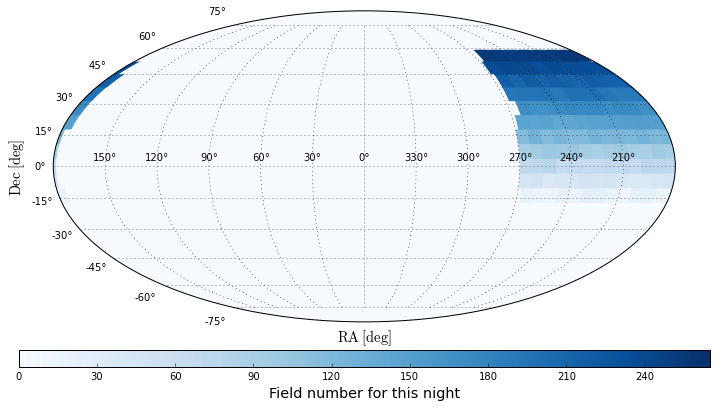

In [6]:
# Example of selected fields (last of the simulated night)
# The fields are number by the order in which they are observed.
vals = np.zeros(bins.nbins)
for k,l in enumerate(field_idx):
    vals[l] = k
    
bins.imshow(vals, cblabel="Field number for this night")

{'ax': <matplotlib.projections.geo.MollweideAxes at 0x7fed64e6c490>,
 'cbar': <matplotlib.colorbar.ColorbarBase instance at 0x7fed6674a950>,
 'collection': <matplotlib.collections.PolyCollection at 0x7fed64eef3d0>,
 'figure': <matplotlib.figure.Figure at 0x7fed669efe90>}

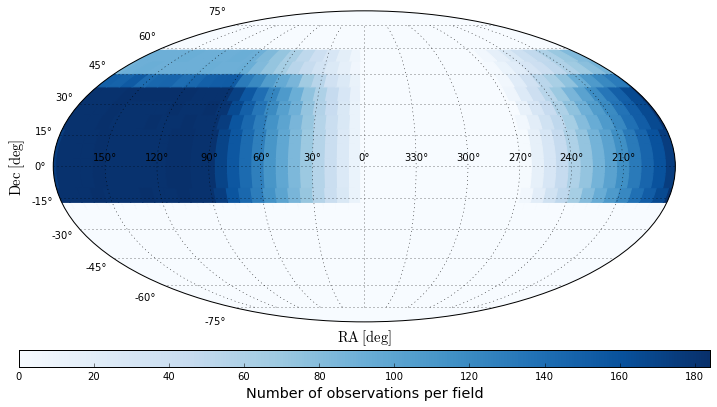

In [7]:
# Number of pointings per field
vals, _ = np.histogram(obs['Field'], bins=range(bins.nbins + 1))
bins.imshow(vals, cblabel="Number of observations per field")

In [8]:
# Make Survey plan
from astrobject.simulation import SurveyPlan
plan = SurveyPlan(mjd=obs['MJD'], band=obs['Band'], obs_field=obs['Field'],
                  fields=dict(ra=ztf_fields[:,1], dec=ztf_fields[:,2]))

# Make a new transient generator limited to the mjd_range of the plan 
# (adding some days for SNe exploding before the plan starts and those with peak after it ends)
tr0 = simul.transient_generator([0.01,0.1], ratekind="basic", type_="Ia", 
                                mjd_range=[obs_days[0] - 60, obs_days[-1] + 25])

In [9]:
observed = plan.observed_on(tr0.ra, tr0.dec, 
                            mjd_range=np.array([tr0.mjd - 20 * (1 + np.array(tr0.zcmb)), 
                                                tr0.mjd + 50 * (1 + np.array(tr0.zcmb))]))
n_obs = np.array([len(a) for a in observed])

SNe observed: 1509 out of 6063


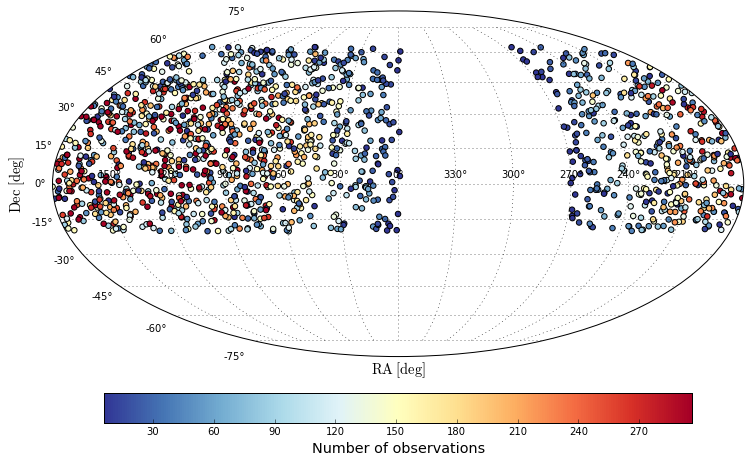

In [10]:
tr0.show_skycoverage(cscale=n_obs, cblabel="Number of observations", mask=(n_obs > 0))
print 'SNe observed: %i out of %i'%(np.sum(n_obs > 0), tr0.ntransient)